# Internet of Things (2IMN25)
### Machine Learning Assignment

### Introduction

The objective of the assignment is to use supervised machine learning techniques to make predictions about the net energy consumed based on the weather conditions. This will be accomplished by training a regression model on (real) data obtained from the weather sensor and energy meter over this year. This model will then be used to make predictions about the net energy consumption for data-points not *seen* by the model during training.

In [152]:
""" Import all libraries here """
import numpy as np
import os
import math
from datetime import datetime
import pandas as pd
from dateutil import parser
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

## Reading the dataset

In the code box below, please read in the data-sets into suitable data structures. The key task here would be to contruct the feature vectors which would be fed to the regression algorithm.

The datasets for the weather, rain and energy consumption have been provided in the zip file, extract this zip file into the same folder as the python notebook. The function should read both the weather and rainfall datafiles and create a merged feature vector array based on time-stamps.



In [153]:
def merge_weather_rain_data(data_path): # Select month for which data is collected
    """ 
    Reads in the CSV files for weather and rain data
    Merged them into a single array based on matching time-stamps
    
    """
        
    """ Read in the weather"""
    weatherFrame = pd.read_csv(os.path.join(data_path,'Weather-Eindhoven.csv'),
                             delimiter = ',',
                             header=0,
                             parse_dates = [0],
                             usecols = [0,1,2,4,6,7]) #Drop "chill", too many missing values
    weather_array  = weatherFrame.as_matrix()

    """ Read in the rain data"""
    rainFrame = pd.read_csv(os.path.join(data_path,'Rain-Best.csv'),
                             delimiter = ',',
                             header =  None,
                             skiprows = 1,
                             index_col = None,
                             parse_dates = [0]
                            )
    rain_array = rainFrame.as_matrix()

    """ Synchronize the 2 data-sets by removing the extra data from the rainfall dataset"""
    remove_rows = []
    for element,idx in zip(rain_array[:,0],range(len(rain_array[:,0]))):
        if element.minute%10 != 0:
            remove_rows.append(idx)

    synced_rain_array = np.delete(rain_array,remove_rows,axis = 0)

    print(synced_rain_array.shape)
    print(weather_array[:,0].shape)

    """ Merge the weather and rain data when time-stamps are equal """
    merged_array = []
    for rainElem in synced_rain_array:
        try :
            merged_row = []
            valid_row = list(weather_array[:,0]).index(rainElem[0])
            for weatherFeature in weather_array[valid_row]:
                merged_row.append(weatherFeature)
            merged_row.append(rainElem[1])
            merged_row.append(weather_array[valid_row][0].hour) # Add "time of day" information 
            merged_array.append(np.asarray(merged_row))
        except ValueError:
            print('Did not find matching timestamp in the weather data, continuing')
            continue

    merged_array = np.asarray(merged_array)
    return merged_array

# Create the merged array
data_path = os.path.join(os.getcwd(),'data')
merged_array = merge_weather_rain_data(data_path)

(43844, 2)
(43872,)
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matchin

## Cleaning the data

The datafiles may contain missing entries, in such an event, it is needed to get rid of such datapoints. The function should take in the created feature vector array and delete rows if features are missing.


In [160]:

def clean_up(merged_array):
    """ 
    Clean up the data by removing rows with missing data points 
    
    """
    missing_data_rows = []
    for row,idx in zip(merged_array,range(merged_array.shape[0])):
        for elem in row[1:]: #Timestamp,Description cannot be "checked"
            if pd.isnull(elem):
                missing_data_rows.append(idx)
                break # To prevent the same row from being added multiple times to the list, break when the first "nan" is found
    clean_data_array = np.delete(merged_array,missing_data_rows,axis=0)
    return clean_data_array

def filter_by_month(data_array,month):
    """
    Filter weather data by month
    
    """
    rows_delete = []
    for row,idx in zip(data_array,range(data_array.shape[0])):
        if row[0].month != month:
            rows_delete.append(idx)
    filtered_array = np.delete(data_array,rows_delete,axis=0)
    return filtered_array

clean_data_array = clean_up(merged_array)
month_array = filter_by_month(clean_data_array,month = 7)

[Timestamp('2017-07-01 00:00:00') 'lichte motregen' 15.5 90.0 2.0 10700.0
 0.27384200000000003 0]


## Reading in the energy values

The aim of the assignment is to predict the solar energy produced based on the weather conditions. Thus, for each weather datapoint, the solar energy must be calclulated using the energy datafiles and matching the time-stamps. Define a function that first creates a single datastructure from all the different energy files. Then, design a function that can perform an energy look-up based on the time-stamp of the weather data. This fucntion should return the total solar energy produced between the previous timestamp and current timestamp.Using this look-up function, loop over all the time-stamps of the weather data and generate energy labels. It should be noted, that for certain time-stamps, the energy values might be missing, datapoints corresponding to such timestamps must be deleted from the data array. 

*Hint : Check the documentation for the python package pandas to design a fast lookup function*

In [155]:
def create_dataframe(energyDir):
    """ 
    Returns a dataframe that is formed by concatenating all the energy data files 
    """
    fileList = []
    energyDir = os.path.join(os.getcwd(),energyDir)
    dirList = [os.path.join(energyDir, o) for o in os.listdir(energyDir) 
                    if os.path.isdir(os.path.join(energyDir,o))]
    
    sortedDirList = sorted(dirList)
    for direc in sortedDirList:
        dirFiles = [os.path.join(direc, f) for f in os.listdir(direc) 
                    if os.path.isfile(os.path.join(direc,f))]
        for f in dirFiles:
            fileList.append(f)
        
    fileList = sorted(fileList)
    frame = pd.DataFrame()
    frameList = []
    for f in fileList:
        try:
            df = pd.read_csv(f,index_col=None, header=None,parse_dates=[[0,1]],skipfooter=2)
            frameList.append(df)
        except:
            continue
    frame = pd.concat(frameList)
    sparseFrame = frame.drop([2,3,4,5,6,7,8,9,13],axis=1)
    sparseFrame.columns = ['TimeStamp','Energy Consumed','Energy Produced','Solar Energy Produced']
    return sparseFrame
    
def energy_frame_month(energyDir,month):
    """
    Create an energy frame for only one month
    
    """
    energyDir = os.path.join(os.getcwd(),energyDir)
    if month < 10:
        monthDir = os.path.join(energyDir,'0{}'.format(month))
    else:
        monthDir = os.path.join(energyDir,'{}'.format(month))
        
    dirFiles = [os.path.join(monthDir, f) for f in os.listdir(monthDir) 
                    if os.path.isfile(os.path.join(monthDir,f))]
    fileList = []
    for f in dirFiles:
        fileList.append(f)
        fileList = sorted(fileList)
    frame = pd.DataFrame()
    frameList = []
    for f in fileList:
        try:
            df = pd.read_csv(f,index_col=None, header=None,parse_dates=[[0,1]],skipfooter=2)
            frameList.append(df)
        except:
            continue
    frame = pd.concat(frameList)
    sparseFrame = frame.drop([2,3,4,5,6,7,8,9,13],axis=1)
    sparseFrame.columns = ['TimeStamp','Energy Consumed','Energy Produced','Solar Energy Produced']
    return sparseFrame

    

    
energyFrame = energy_frame_month('data/2017',month = 7)
print(energyFrame)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:52: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


               TimeStamp  Energy Consumed  Energy Produced  \
0    2017-07-01 00:00:01              860                0   
1    2017-07-01 00:00:11             1030                0   
2    2017-07-01 00:00:21             1020                0   
3    2017-07-01 00:00:31             1110                0   
4    2017-07-01 00:00:41             1010                0   
5    2017-07-01 00:00:51              880                0   
6    2017-07-01 00:01:01             1000                0   
7    2017-07-01 00:01:11              880                0   
8    2017-07-01 00:01:21             1010                0   
9    2017-07-01 00:01:31             1010                0   
10   2017-07-01 00:01:41              880                0   
11   2017-07-01 00:01:51             1020                0   
12   2017-07-01 00:02:01              880                0   
13   2017-07-01 00:02:11              990                0   
14   2017-07-01 00:02:21              870                0   
15   201

In [156]:
def energy_lookup(data_array,energyFrame,idx):
    """ 
    Given the index, calculated the net-energy consumed in the 10-minute interval preceeding current time
    
    """
    try:
        subFrame = energyFrame[(energyFrame['TimeStamp']>data_array[idx-1][0]) & (energyFrame['TimeStamp']<data_array[idx][0])]
        if subFrame.shape[0] == 0:
            return None,None
        energyList = []
        solarList = []
        for cons,prod,solar in zip(subFrame['Energy Consumed'],subFrame['Energy Produced'],subFrame['Solar Energy Produced']):
            energyList.append(cons-prod)
            solarList.append(solar)
        return np.sum(np.asarray(energyList)),np.sum(np.asarray(solar))
    except:
        return None,None

def create_labels(data_array,energyFrame):
    """
    Uses the look-up function to create labels (if possible)
    for every feature vector in the feature array.
    
    """
    
    missing_labels = []
    labels = []
    labels_solar = []
    labels.append(0)
    labels_solar.append(0)
    energyFrame['TimeStamp'] = pd.to_datetime(energyFrame['TimeStamp']) 
    for row,idx in zip(data_array,range(data_array.shape[0])):
        if idx == 0:
            continue
        netEnergy,netSolar = energy_lookup(data_array,energyFrame,idx)
        if netEnergy is None and netSolar is None:
            print('Missing label for row {}'.format(idx))
            missing_labels.append(idx)
        else:
            print('{} {} {}'.format(row[0],netEnergy,netSolar))
            labels.append(netEnergy)
            labels_solar.append(netSolar)
    return labels,labels_solar,missing_labels

labels,labels_solar,missing_labels = create_labels(month_array,energyFrame)
featureArray = np.delete(month_array,missing_labels,axis=0)
            

2017-07-01 00:10:00 55550 0
2017-07-01 00:20:00 51920 0
2017-07-01 00:30:00 76330 0
2017-07-01 00:40:00 47950 0
2017-07-01 00:50:00 46520 0
2017-07-01 01:00:00 46610 0
2017-07-01 01:10:00 40380 0
2017-07-01 01:20:00 45540 0
2017-07-01 01:30:00 34430 0
2017-07-01 01:40:00 39770 0
2017-07-01 01:50:00 43950 0
2017-07-01 02:00:00 27720 0
2017-07-01 02:10:00 25060 0
2017-07-01 02:20:00 18700 0
2017-07-01 02:30:00 14050 0
2017-07-01 02:40:00 20250 0
2017-07-01 02:50:00 52530 0
2017-07-01 03:00:00 24530 0
2017-07-01 03:10:00 19160 0
2017-07-01 03:20:00 16510 0
2017-07-01 03:30:00 14400 0
2017-07-01 03:40:00 12530 0
2017-07-01 03:50:00 10230 0
2017-07-01 04:00:00 8400 0
2017-07-01 04:10:00 12280 0
2017-07-01 04:20:00 8580 0
2017-07-01 04:30:00 9210 0
2017-07-01 04:40:00 18460 0
2017-07-01 04:50:00 19870 0
2017-07-01 05:00:00 20760 0
2017-07-01 05:10:00 21150 0
2017-07-01 05:20:00 14990 0
2017-07-01 05:30:00 14930 0
2017-07-01 05:40:00 12370 0
2017-07-01 05:50:00 8240 0
2017-07-01 06:00:00 1099

2017-07-03 00:00:00 35940 0
2017-07-03 00:10:00 39390 0
2017-07-03 00:20:00 38170 0
2017-07-03 00:30:00 26400 0
2017-07-03 00:40:00 32330 0
2017-07-03 00:50:00 32570 0
2017-07-03 01:00:00 40800 0
2017-07-03 01:10:00 21860 0
2017-07-03 01:20:00 18060 0
2017-07-03 01:30:00 17270 0
2017-07-03 01:40:00 15010 0
2017-07-03 01:50:00 16990 0
2017-07-03 02:00:00 10850 0
2017-07-03 02:10:00 9360 0
2017-07-03 02:20:00 12000 0
2017-07-03 02:30:00 11950 0
2017-07-03 02:40:00 10200 0
2017-07-03 02:50:00 18160 0
2017-07-03 03:00:00 24270 0
2017-07-03 03:10:00 20710 0
2017-07-03 03:20:00 21840 0
2017-07-03 03:30:00 19070 0
2017-07-03 03:40:00 11550 0
2017-07-03 03:50:00 10900 0
2017-07-03 04:00:00 29910 0
2017-07-03 04:10:00 9620 0
2017-07-03 04:20:00 10130 0
2017-07-03 04:30:00 19190 0
2017-07-03 04:40:00 15590 0
2017-07-03 04:50:00 15020 0
2017-07-03 05:00:00 15520 0
2017-07-03 05:10:00 10200 0
2017-07-03 05:20:00 9600 0
2017-07-03 05:30:00 12640 0
2017-07-03 05:40:00 10730 54
2017-07-03 05:50:00 89

2017-07-05 02:00:00 20480 0
2017-07-05 02:10:00 44600 0
2017-07-05 02:20:00 31150 0
2017-07-05 02:30:00 26050 0
2017-07-05 02:40:00 19830 0
2017-07-05 02:50:00 18230 0
2017-07-05 03:00:00 12290 0
2017-07-05 03:10:00 9210 0
2017-07-05 03:20:00 13910 0
2017-07-05 03:30:00 10330 0
2017-07-05 03:40:00 10850 0
2017-07-05 03:50:00 15930 0
2017-07-05 04:00:00 16250 0
2017-07-05 04:10:00 16140 0
2017-07-05 04:20:00 19130 0
2017-07-05 04:30:00 11080 0
2017-07-05 04:40:00 10880 0
2017-07-05 04:50:00 17610 0
2017-07-05 05:00:00 15470 0
2017-07-05 05:10:00 16530 0
2017-07-05 05:20:00 19320 0
2017-07-05 05:30:00 20600 0
2017-07-05 05:40:00 18640 0
2017-07-05 05:50:00 37460 66
2017-07-05 06:00:00 8280 39
2017-07-05 06:10:00 8190 100
2017-07-05 06:20:00 12250 71
2017-07-05 06:30:00 9290 48
2017-07-05 06:40:00 12530 57
2017-07-05 06:50:00 16110 59
2017-07-05 07:00:00 15450 57
2017-07-05 07:10:00 8830 271
2017-07-05 07:20:00 -3200 494
2017-07-05 07:30:00 -13100 512
2017-07-05 07:40:00 15600 546
2017-07

2017-07-06 23:40:00 47480 0
2017-07-06 23:50:00 45220 0
2017-07-07 00:00:00 48160 0
2017-07-07 00:10:00 45210 0
2017-07-07 00:20:00 45190 0
2017-07-07 00:30:00 34270 0
2017-07-07 00:40:00 59590 0
2017-07-07 00:50:00 28190 0
2017-07-07 01:00:00 26780 0
2017-07-07 01:10:00 22870 0
2017-07-07 01:20:00 23750 0
2017-07-07 01:30:00 25240 0
2017-07-07 01:40:00 22820 0
2017-07-07 01:50:00 23600 0
2017-07-07 02:00:00 13170 0
2017-07-07 02:10:00 15190 0
2017-07-07 02:20:00 13610 0
2017-07-07 02:30:00 13610 0
2017-07-07 02:40:00 13110 0
2017-07-07 02:50:00 11620 0
2017-07-07 03:00:00 20620 0
2017-07-07 03:10:00 16380 0
2017-07-07 03:20:00 23960 0
2017-07-07 03:30:00 22060 0
2017-07-07 03:40:00 21180 0
2017-07-07 03:50:00 19440 0
2017-07-07 04:00:00 14640 0
2017-07-07 04:10:00 14210 0
2017-07-07 04:20:00 31110 0
2017-07-07 04:30:00 12570 0
2017-07-07 04:40:00 13320 0
2017-07-07 04:50:00 16820 0
2017-07-07 05:00:00 18790 0
2017-07-07 05:10:00 15080 0
2017-07-07 05:20:00 18530 0
2017-07-07 05:30:00 

2017-07-09 06:50:00 16950 56
2017-07-09 07:00:00 19960 58
2017-07-09 07:10:00 1410 337
2017-07-09 07:20:00 -1380 471
2017-07-09 07:30:00 6670 379
2017-07-09 07:40:00 2680 772
2017-07-09 07:50:00 -22410 868
2017-07-09 08:00:00 -30940 951
2017-07-09 08:10:00 -40880 1008
2017-07-09 08:20:00 -46140 1150
2017-07-09 08:30:00 -53660 1230
2017-07-09 08:40:00 -57510 1324
2017-07-09 08:50:00 -54320 1374
2017-07-09 09:00:00 4540 1452
2017-07-09 09:10:00 -44390 1458
2017-07-09 09:20:00 -74500 1608
2017-07-09 09:30:00 -82770 1683
2017-07-09 09:40:00 -84060 1677
2017-07-09 09:50:00 -89040 1795
2017-07-09 10:00:00 -95370 1804
2017-07-09 10:10:00 -96450 1902
2017-07-09 10:20:00 -98780 1940
2017-07-09 10:30:00 -98410 2063
2017-07-09 10:40:00 -98150 2106
2017-07-09 10:50:00 -102910 2125
2017-07-09 11:00:00 -86900 2173
2017-07-09 11:10:00 -103690 2115
2017-07-09 11:20:00 -111490 2218
2017-07-09 11:30:00 -114489 2142
2017-07-09 11:40:00 -108486 2173
2017-07-09 11:50:00 -113004 1960
2017-07-09 12:00:00 -11

2017-07-11 07:50:00 18870 25
2017-07-11 08:00:00 13100 25
2017-07-11 08:10:00 14820 94
2017-07-11 08:20:00 3610 199
2017-07-11 08:30:00 -5890 440
2017-07-11 08:40:00 22930 248
2017-07-11 08:50:00 1840 455
2017-07-11 09:00:00 7650 250
2017-07-11 09:10:00 6450 317
2017-07-11 09:20:00 3300 316
2017-07-11 09:30:00 -6690 315
2017-07-11 09:40:00 -5670 421
2017-07-11 09:50:00 -6180 363
2017-07-11 10:00:00 -8080 334
2017-07-11 10:10:00 -13220 472
2017-07-11 10:20:00 -21920 641
2017-07-11 10:30:00 -19400 465
2017-07-11 10:40:00 -66080 2594
2017-07-11 10:50:00 -59999 1137
2017-07-11 11:00:00 -64020 766
2017-07-11 11:10:00 -72329 2182
2017-07-11 11:20:00 -98700 1062
2017-07-11 11:30:00 -97859 2604
2017-07-11 11:40:00 -32380 862
2017-07-11 11:50:00 -79580 764
2017-07-11 12:00:00 -20450 1447
2017-07-11 12:10:00 -52600 2324
2017-07-11 12:20:00 -11710 538
2017-07-11 12:30:00 -74690 1893
2017-07-11 12:40:00 -68260 1632
2017-07-11 12:50:00 -57090 1282
2017-07-11 13:00:00 -48030 1094
2017-07-11 13:10:00

2017-07-13 09:30:00 -86460 1708
2017-07-13 09:40:00 -87110 1840
2017-07-13 09:50:00 -71190 1794
2017-07-13 10:00:00 -91730 827
2017-07-13 10:10:00 -42620 678
2017-07-13 10:20:00 -14740 573
2017-07-13 10:30:00 -14740 624
2017-07-13 10:40:00 -21760 640
2017-07-13 10:50:00 -48790 1473
2017-07-13 11:00:00 -45620 843
2017-07-13 11:10:00 -37920 1037
2017-07-13 11:20:00 -67070 1216
2017-07-13 11:30:00 -58390 1166
2017-07-13 11:40:00 -109340 1384
2017-07-13 11:50:00 -82790 1532
2017-07-13 12:00:00 -65890 1118
2017-07-13 12:10:00 -83770 1163
2017-07-13 12:20:00 -160380 2917
2017-07-13 12:30:00 -119760 2682
2017-07-13 12:40:00 -53280 1114
2017-07-13 12:50:00 -68420 1446
2017-07-13 13:00:00 -119149 2090
2017-07-13 13:10:00 -124860 2785
2017-07-13 13:20:00 -120620 2840
2017-07-13 13:30:00 -116280 2559
2017-07-13 13:40:00 -88550 1107
2017-07-13 13:50:00 -83920 1323
2017-07-13 14:00:00 -94419 1254
2017-07-13 14:10:00 -99119 1865
2017-07-13 14:20:00 -97519 2406
2017-07-13 14:30:00 -116250 2554
2017-0

2017-07-15 11:00:00 -94818 957
2017-07-15 11:10:00 -102247 1340
2017-07-15 11:20:00 -71979 1881
2017-07-15 11:30:00 -85057 2199
2017-07-15 11:40:00 -88648 2215
2017-07-15 11:50:00 -56080 933
2017-07-15 12:00:00 -85217 2233
2017-07-15 12:10:00 -63750 904
2017-07-15 12:20:00 -62760 1792
2017-07-15 12:30:00 -31720 530
2017-07-15 12:40:00 -28580 1266
2017-07-15 12:50:00 -26200 533
2017-07-15 13:00:00 -31590 1211
2017-07-15 13:10:00 -88580 1942
2017-07-15 13:20:00 -42330 884
2017-07-15 13:30:00 -48980 963
2017-07-15 13:40:00 -66950 929
2017-07-15 13:50:00 -70709 788
2017-07-15 14:00:00 -32720 698
2017-07-15 14:10:00 -34030 836
2017-07-15 14:20:00 -65080 1275
2017-07-15 14:30:00 -57440 1211
2017-07-15 14:40:00 -19190 611
2017-07-15 14:50:00 -11920 541
2017-07-15 15:00:00 -23300 643
2017-07-15 15:10:00 -42440 856
2017-07-15 15:20:00 -72289 2301
2017-07-15 15:30:00 -45250 590
2017-07-15 15:40:00 -10840 496
2017-07-15 15:50:00 -26160 632
2017-07-15 16:00:00 26430 360
2017-07-15 16:10:00 -12900 

2017-07-17 12:30:00 -127739 2339
2017-07-17 12:40:00 -124203 2383
2017-07-17 12:50:00 -127039 2341
2017-07-17 13:00:00 -124318 2278
2017-07-17 13:10:00 -93417 2262
2017-07-17 13:20:00 -125417 2363
2017-07-17 13:30:00 -126097 2333
2017-07-17 13:40:00 -129720 2311
2017-07-17 13:50:00 -127768 2267
2017-07-17 14:00:00 -120273 2254
2017-07-17 14:10:00 -121397 2188
2017-07-17 14:20:00 -117799 2146
2017-07-17 14:30:00 -111000 2075
2017-07-17 14:40:00 -112790 2123
2017-07-17 14:50:00 -108530 2067
2017-07-17 15:00:00 -104160 1992
2017-07-17 15:10:00 -104780 1940
2017-07-17 15:20:00 -102860 1889
2017-07-17 15:30:00 -95210 1845
2017-07-17 15:40:00 -69060 1774
2017-07-17 15:50:00 -89800 1686
2017-07-17 16:00:00 -83330 1643
2017-07-17 16:10:00 -81120 1558
2017-07-17 16:20:00 -81730 1506
2017-07-17 16:30:00 -72650 1382
2017-07-17 16:40:00 -71570 1297
2017-07-17 16:50:00 -32510 1284
2017-07-17 17:00:00 -47530 1221
2017-07-17 17:10:00 -41410 1121
2017-07-17 17:20:00 -37010 1027
2017-07-17 17:30:00 -23

Missing label for row 2627
Missing label for row 2628
Missing label for row 2629
Missing label for row 2630
Missing label for row 2631
Missing label for row 2632
Missing label for row 2633
Missing label for row 2634
Missing label for row 2635
Missing label for row 2636
Missing label for row 2637
Missing label for row 2638
Missing label for row 2639
Missing label for row 2640
Missing label for row 2641
Missing label for row 2642
Missing label for row 2643
Missing label for row 2644
Missing label for row 2645
Missing label for row 2646
Missing label for row 2647
Missing label for row 2648
Missing label for row 2649
Missing label for row 2650
Missing label for row 2651
Missing label for row 2652
Missing label for row 2653
Missing label for row 2654
Missing label for row 2655
Missing label for row 2656
Missing label for row 2657
Missing label for row 2658
Missing label for row 2659
Missing label for row 2660
Missing label for row 2661
Missing label for row 2662
Missing label for row 2663
M

2017-07-21 14:40:00 -91360 2137
2017-07-21 14:50:00 -90690 2112
2017-07-21 15:00:00 -1090 2092
2017-07-21 15:10:00 -94650 2046
2017-07-21 15:20:00 -86300 1798
2017-07-21 15:30:00 -73560 1791
2017-07-21 15:40:00 -74120 1748
2017-07-21 15:50:00 15710 1669
2017-07-21 16:00:00 75290 1613
2017-07-21 16:10:00 23340 1633
2017-07-21 16:20:00 57750 556
2017-07-21 16:30:00 34520 1514
2017-07-21 16:40:00 21610 1395
2017-07-21 16:50:00 42360 1306
2017-07-21 17:00:00 16100 1213
2017-07-21 17:10:00 -28880 1076
2017-07-21 17:20:00 -28800 974
2017-07-21 17:30:00 -3520 925
2017-07-21 17:40:00 -16120 799
2017-07-21 17:50:00 -10380 702
2017-07-21 18:00:00 -6360 601
2017-07-21 18:10:00 2890 518
2017-07-21 18:20:00 6270 374
2017-07-21 18:30:00 14710 325
2017-07-21 18:40:00 45780 258
2017-07-21 18:50:00 32740 205
2017-07-21 19:00:00 42350 206
2017-07-21 19:10:00 41610 200
2017-07-21 19:20:00 30050 177
2017-07-21 19:30:00 41750 249
2017-07-21 19:40:00 40930 223
2017-07-21 19:50:00 28560 267
2017-07-21 20:00:

2017-07-23 16:20:00 1090 249
2017-07-23 16:30:00 25830 80
2017-07-23 16:40:00 31770 78
2017-07-23 16:50:00 29450 67
2017-07-23 17:00:00 28380 57
2017-07-23 17:10:00 28910 8
2017-07-23 17:20:00 21480 14
2017-07-23 17:30:00 2060 348
2017-07-23 17:40:00 16830 349
2017-07-23 17:50:00 5200 397
2017-07-23 18:00:00 16270 207
2017-07-23 18:10:00 25720 243
2017-07-23 18:20:00 18100 273
2017-07-23 18:30:00 11680 170
2017-07-23 18:40:00 20310 235
2017-07-23 18:50:00 16899 186
2017-07-23 19:00:00 40200 69
2017-07-23 19:10:00 34400 68
2017-07-23 19:20:00 32360 77
2017-07-23 19:30:00 29960 134
2017-07-23 19:40:00 15630 79
2017-07-23 19:50:00 22830 90
2017-07-23 20:00:00 23840 67
2017-07-23 20:10:00 25270 82
2017-07-23 20:20:00 30660 89
2017-07-23 20:30:00 30590 61
2017-07-23 20:40:00 22770 90
2017-07-23 20:50:00 22050 73
2017-07-23 21:00:00 24600 59
2017-07-23 21:10:00 27180 0
2017-07-23 21:20:00 30210 0
2017-07-23 21:30:00 52700 0
2017-07-23 21:40:00 28620 0
2017-07-23 21:50:00 29550 0
2017-07-23 2

2017-07-25 17:20:00 -320 571
2017-07-25 17:30:00 1850 366
2017-07-25 17:40:00 1160 386
2017-07-25 17:50:00 2810 460
2017-07-25 18:00:00 9630 208
2017-07-25 18:10:00 9650 197
2017-07-25 18:20:00 64140 78
2017-07-25 18:30:00 110730 67
2017-07-25 18:40:00 77780 72
2017-07-25 18:50:00 19910 89
2017-07-25 19:00:00 20120 86
2017-07-25 19:10:00 19230 106
2017-07-25 19:20:00 22680 88
2017-07-25 19:30:00 21050 11
2017-07-25 19:40:00 29640 75
2017-07-25 19:50:00 57610 78
2017-07-25 20:00:00 36340 109
2017-07-25 20:10:00 30750 76
2017-07-25 20:20:00 31850 80
2017-07-25 20:30:00 30360 94
2017-07-25 20:40:00 31180 64
2017-07-25 20:50:00 34290 28
2017-07-25 21:00:00 33640 0
2017-07-25 21:10:00 37460 0
2017-07-25 21:20:00 41240 0
2017-07-25 21:30:00 41260 0
2017-07-25 21:40:00 38290 0
2017-07-25 21:50:00 41040 0
2017-07-25 22:00:00 56840 0
2017-07-25 22:10:00 34400 0
2017-07-25 22:20:00 120670 0
2017-07-25 22:30:00 112420 0
2017-07-25 22:40:00 40850 0
2017-07-25 22:50:00 42740 0
2017-07-25 23:00:00 6

2017-07-27 18:40:00 18040 336
2017-07-27 18:50:00 28690 336
2017-07-27 19:00:00 30260 336
2017-07-27 19:10:00 2340 336
2017-07-27 19:20:00 20990 336
2017-07-27 19:30:00 36069 336
2017-07-27 19:40:00 7430 336
2017-07-27 19:50:00 40670 336
2017-07-27 20:00:00 57180 336
2017-07-27 20:10:00 24680 336
2017-07-27 20:20:00 50380 336
2017-07-27 20:30:00 31020 336
2017-07-27 20:40:00 20980 336
2017-07-27 20:50:00 16210 336
2017-07-27 21:00:00 12410 336
2017-07-27 21:10:00 14810 336
2017-07-27 21:20:00 15910 336
2017-07-27 21:30:00 13960 336
2017-07-27 21:40:00 23470 336
2017-07-27 21:50:00 21440 336
2017-07-27 22:00:00 22070 336
2017-07-27 22:10:00 23200 336
2017-07-27 22:20:00 17120 336
2017-07-27 22:30:00 19200 336
2017-07-27 22:40:00 21740 336
2017-07-27 22:50:00 18950 336
2017-07-27 23:00:00 24960 336
2017-07-27 23:10:00 27640 336
2017-07-27 23:20:00 52800 336
2017-07-27 23:30:00 32140 336
2017-07-27 23:40:00 29790 336
2017-07-27 23:50:00 22470 0
2017-07-28 00:00:00 25300 0
2017-07-28 00:10

2017-07-29 20:40:00 22130 130
2017-07-29 20:50:00 30360 92
2017-07-29 21:00:00 35210 67
2017-07-29 21:10:00 32260 61
2017-07-29 21:20:00 37180 55
2017-07-29 21:30:00 36330 0
2017-07-29 21:40:00 31410 0
2017-07-29 21:50:00 54590 0
2017-07-29 22:00:00 33990 0
2017-07-29 22:10:00 19800 0
2017-07-29 22:20:00 21340 0
2017-07-29 22:30:00 24210 0
2017-07-29 22:40:00 25760 0
2017-07-29 22:50:00 24630 0
2017-07-29 23:00:00 22980 0
2017-07-29 23:10:00 22170 0
2017-07-29 23:20:00 17810 0
2017-07-29 23:30:00 19720 0
2017-07-29 23:40:00 20020 0
2017-07-29 23:50:00 16720 0
2017-07-30 00:00:00 23020 0
2017-07-30 00:10:00 30140 0
2017-07-30 00:20:00 30190 0
2017-07-30 00:30:00 31860 0
2017-07-30 00:40:00 26980 0
2017-07-30 00:50:00 24580 0
2017-07-30 01:00:00 40290 0
2017-07-30 01:10:00 17420 0
2017-07-30 01:20:00 16070 0
2017-07-30 01:30:00 12930 0
2017-07-30 01:40:00 15730 0
2017-07-30 01:50:00 22040 0
2017-07-30 02:00:00 17040 0
2017-07-30 02:10:00 18450 0
2017-07-30 02:20:00 17830 0
2017-07-30 02:

2017-07-31 22:40:00 22960 0
2017-07-31 22:50:00 19240 0
2017-07-31 23:00:00 36180 0
2017-07-31 23:10:00 12230 0
2017-07-31 23:20:00 21890 0
2017-07-31 23:30:00 20270 0
2017-07-31 23:40:00 18970 0
2017-07-31 23:50:00 24050 0


## Splitting the dataset

Split the data-set into train, validation and test sets. The train set is used to calculate the regression co-efficients, the validation set is used to check the accuracy of the regression model and parameters can be tweaked such that the validation accuracy is improved. Finally, the test-set is the truly *unseen* data. [I think, this function should be provided - Ishaan]

In [157]:
def split_dataset(featureArray,labels):
    """ 
    Splits data-set into train,val and test
    
    """
    
    data_train = []
    label_train = []
    data_val = []
    label_val = []
    data_test = []
    label_test = []
    for row,idx,label in zip(featureArray,range(featureArray.shape[0]),labels):
        if row[0].day <= 20:
            data_train.append(row)
            label_train.append(label)
        elif row[0].day <=25:
            data_val.append(row)
            label_val.append(label)
        else:
            data_test.append(row)
            label_test.append(label)
    return np.asarray(data_train),label_train,np.asarray(data_val),label_val,np.asarray(data_test),label_test

In [158]:
import matplotlib.pyplot as plt
%matplotlib inline

def transform_text_labels(featureArray):
    """
    Takes the text based labels and transforms them into a one-hot encoded
    feature matrix, could be appended to original feature array
    """
    # Use the label encoder to convert text based features to ints
    le = LabelEncoder()
    textList = list(featureArray[:,1])
    le.fit(textList)
    intList = le.transform(textList) 
    distinctLabels = list(set(intList))
    n, bins, patches = plt.hist(intList, bins = 20)
    plt.show()
    # Choose relevant class labels
    max_occ = max(n) # Gives the text label with max occurences in the data-set
    relevant_classes = []
    # Generate one-hot encoded matrix
    for item,idx in zip(n,range(len(n))):
        if item > max_occ/2:
            relevant_classes.append(idx)
    transMatrix = np.zeros((len(intList),len(relevant_classes)),dtype = np.int)
    for idx,elem in zip(range(transMatrix.shape[0]),intList):
        if elem in relevant_classes:
            transMatrix[idx][relevant_classes.index(elem)] = 1
    return transMatrix        

## Visualizing the data

It is always good to visualize the correlations between different columns of the data-set. It is also very instructive to see how the label values behave w.r.t each individual feature. 

*Hint : Check the documentation for the scatter_matrix from the pandas package*

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0e24fa6a0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb0e18e6400>]], dtype=object)

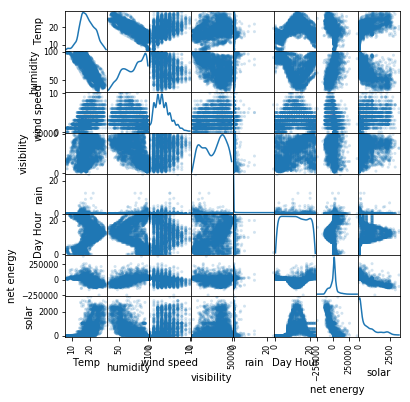

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline

#Merge energy and solar energy produced into feature array
mergedMatrix = np.c_[featureArray,labels,labels_solar]
#Create a pandas dataframe for viz
scatterMatrix = mergedMatrix[:,2:].astype(float)
df = pd.DataFrame(data = scatterMatrix,
                  columns = ['Temp','humidity',
                              'wind speed','visibility',
                              'rain','Day Hour',
                              'net energy','solar']
                 )

pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')

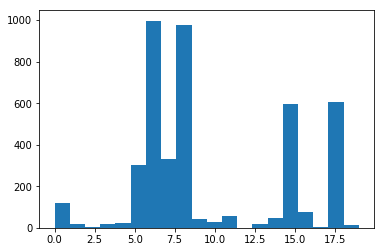

(4276, 12)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0e16ff1d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb0e3e41a58>]], dtype=object)

In [ ]:
transMatrix = transform_text_labels(featureArray)
merge = np.c_[featureArray,transMatrix]
merge_hot = np.c_[transMatrix,labels_solar]
print(merge.shape)
scatterMatrix = merge_hot.astype(float)
df = pd.DataFrame(data = scatterMatrix)

pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')


## Creating a regression model

At this point, we have a clean feature matrix (split into 3 sets) with the corresponding set of labels. Define a helper function to calculate the prediction error for validations and test sets. Define another function that normalizes the feature vector columns. 

Finally use the regression model from scikit-learn to fit training data. Tweak parameters and check their effect by calculating the prediction error for the validation set.

When the best set of parameters are found, check the prediction error on the test-set.

In [ ]:
def prediction_error(labels_predict,labels_true):
    """
    Calculates the prediction error as the average absolute difference 
    between predicted and true labels
    
    """
    error = 0
    for predicted,true in zip(labels_predict,labels_true):
        #print('True : {} Predicted : {}'.format(true,predicted))
        error += abs(predicted-true)
    
    error = error/len(labels_predict)
    return error

def normalize_data(data):
    """
    Scales data to [-1,1], to be done before feeding it for regression
    
    """
    scaler = StandardScaler()
    fit = scaler.fit_transform(data)
    return fit

#Split the dataset
data_train,label_train,data_val,label_val,data_test,label_test = split_dataset(featureArray,labels_solar)

# SGD Regression (Don't normalize the one hot encoded labels !)
X_train = normalize_data(data_train[:,2:].astype(float))
X_val = normalize_data(data_val[:,2:].astype(float))
X_test = normalize_data(data_test[:,2:].astype(float))
print(X_train.shape)
clf = linear_model.SGDRegressor(max_iter = 10**6/X_train.shape[0],
                                tol = 1e-6,
                                alpha = 0.0001,
                                )
clf.fit(X_train,labels_train)

print(clf.coef_)

print(prediction_error(clf.predict(X_val),labels_val))
print(prediction_error(clf.predict(X_test),labels_test))


In [ ]:
# Ridge Regression
ridge = linear_model.Ridge(alpha=1.0)
ridge.fit(X_train,labels_train)
print(ridge.coef_)

print(prediction_error(ridge.predict(X_val),labels_val))
#print(prediction_error(ridge.predict(X_test),labels_test))

In [ ]:
# Lasso Regression
lasso = linear_model.Lasso(alpha=1.0)
lasso.fit(X_train,labels_train)
print(lasso.coef_)

print(prediction_error(lasso.predict(X_val),labels_val))
print(prediction_error(lasso.predict(X_test),labels_test))